# 卫星图片分类

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
%matplotlib inline

## 创建数据路径

In [3]:
# 数据目录
data_dir = "dataset/satellite_picture"

data_root = pathlib.Path(data_dir)
# 所有文件的路径
all_image_paths = list(data_root.glob('*/*'))
all_image_paths[:3]

[WindowsPath('dataset/satellite_picture/airplane/airplane_001.jpg'),
 WindowsPath('dataset/satellite_picture/airplane/airplane_002.jpg'),
 WindowsPath('dataset/satellite_picture/airplane/airplane_003.jpg')]

In [4]:
# 转为字符串
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths[:3]

['dataset\\satellite_picture\\airplane\\airplane_001.jpg',
 'dataset\\satellite_picture\\airplane\\airplane_002.jpg',
 'dataset\\satellite_picture\\airplane\\airplane_003.jpg']

In [5]:
# 数据集总数
image_num = len(all_image_paths)
image_num

1400

## 创建数据集

In [6]:
# 加载图片的函数
def load_one_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

In [7]:
image_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_dataset = image_dataset.map(load_one_image)
image_dataset

<MapDataset shapes: (256, 256, 3), types: tf.float32>

## 创建标签

In [8]:
# 标签的名字
label_names = sorted([item.name for item in data_root.glob('*/')])
label_names

['airplane', 'lake']

In [9]:
# 标签名字到标签序号
name_to_index = dict((name, index) for index, name in enumerate(label_names))
name_to_index

{'airplane': 0, 'lake': 1}

In [10]:
label_dataset = [name_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
label_dataset[0:3]

[0, 0, 0]

In [11]:
label_dataset = tf.data.Dataset.from_tensor_slices(label_dataset)
label_dataset

<TensorSliceDataset shapes: (), types: tf.int32>

## 合并数据和标签

In [12]:
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
dataset

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

## 分离训练集和验证集

In [13]:
dataset = dataset.shuffle(image_num)

In [14]:
validation_num = int(image_num * 0.2)
train_num = image_num - validation_num
print("train_num:", train_num)
print("validation_num:", validation_num)
train_data = dataset.skip(validation_num)
validation_data = dataset.take(validation_num)
print("train_data:", train_data)
print("validation_data:", validation_data)

train_num: 1120
validation_num: 280
train_data: <SkipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>
validation_data: <TakeDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>


In [15]:
BATCH_SIZE = 32
train_data = train_data.shuffle(train_num).repeat().batch(BATCH_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
print("train_data:", train_data)
print("validation_data:", validation_data)

train_data: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>
validation_data: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


## 构建模型训练

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [17]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
)

In [18]:
train_steps = train_num // BATCH_SIZE
val_steps = validation_num // BATCH_SIZE
train_history = model.fit(train_data,
                          epochs = 10,
                          steps_per_epoch = train_steps,
                          validation_data = validation_data,
                          validation_steps = val_steps
)

Train for 35 steps, validate for 8 steps
Epoch 1/10
35/35 [==============================] - 44s 1s/step - loss: 0.6859 - accuracy: 0.5429 - val_loss: 0.6450 - val_accuracy: 0.5000
Epoch 2/10
35/35 [==============================] - 37s 1s/step - loss: 0.5972 - accuracy: 0.7348 - val_loss: 0.3175 - val_accuracy: 0.8594
Epoch 3/10
35/35 [==============================] - 36s 1s/step - loss: 0.2806 - accuracy: 0.9098 - val_loss: 0.1526 - val_accuracy: 0.9453
Epoch 4/10
35/35 [==============================] - 36s 1s/step - loss: 0.1678 - accuracy: 0.9500 - val_loss: 0.1324 - val_accuracy: 0.9570
Epoch 5/10
35/35 [==============================] - 36s 1s/step - loss: 0.1189 - accuracy: 0.9652 - val_loss: 0.1354 - val_accuracy: 0.9453
Epoch 6/10
35/35 [==============================] - 36s 1s/step - loss: 0.1715 - accuracy: 0.9536 - val_loss: 0.1589 - val_accuracy: 0.9766
Epoch 7/10
35/35 [==============================] - 36s 1s/step - loss: 0.1573 - accuracy: 0.9580 - val_loss: 0.0486 - 

## 训练过程可视化

In [19]:
train_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

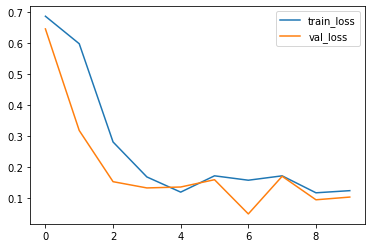

In [20]:
train_loss = train_history.history["loss"]
train_acc = train_history.history["accuracy"]
val_loss = train_history.history["val_loss"]
val_acc = train_history.history["val_accuracy"]

plt.plot(train_history.epoch, train_loss, label='train_loss')
plt.plot(train_history.epoch, val_loss, label='val_loss')
plt.legend()

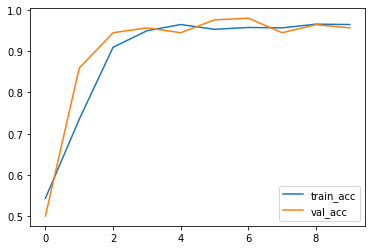

In [21]:
plt.plot(train_history.epoch, train_acc, label='train_acc')
plt.plot(train_history.epoch, val_acc, label='val_acc')
plt.legend()